# Image Captioning with CNN (Xception) and RNN (LSTM)

In this notebook, I will make a Deep Learning Model for image captioning. This model is combination of CNN and RNN and will be trained on flickr8k dataset. A convolutional neural network can be used to create a dense feature vector. This dense vector, also called an embedding, can be used as feature input into other algorithms or networks, in this case, will be used as the initial state of the LSTM. LSTM is a recurrent neural network architecture that is commonly used in problems with temporal dependences.

## Import Libraries

In [10]:
import numpy as np                                      # matrix operation
from PIL import Image                                   # to open image
import os, csv                                          # to read file
import string                                           # string processing
from pickle import dump, load                           # save and load from pickle file
from keras.applications.xception import Xception        # get pre-trained model Xception
from keras.preprocessing.text import Tokenizer          # for text tokenization
from keras.preprocessing.sequence import pad_sequences  # for padding sequence
from tensorflow.keras.utils import to_categorical       # one hot
from keras.layers.merge import add                      # DL layers
from keras.models import Model, load_model              # DL layers
from keras.layers import Input, Dense                   # DL layers
from keras.layers import LSTM, Embedding, Dropout       # DL layers
from tqdm.notebook import tqdm                          # check loop progress
from nltk.translate.bleu_score import corpus_bleu       # metrics for model

# English Version

## Understanding Data

Dataset are downloaded from kaggle [Flickr 8k Dataset](https://www.kaggle.com/datasets/adityajn105/flickr8k) <br>
This dataset contains 8000 images each with 5 captions

"./dataset/Images" : Contains a total of 8092 images in JPEG format.<br>
"./dataset/captions.txt" : Contains 5 captions for each image i.e. total 40460 captions.<br>
Preview:
![data preview](./notebook_images/data.png "Data preview")


Indonesian captions are downloaded from github [Amazing Bahasa Indonesia Image Captioning](https://github.com/adityaalifn/indonesia-image-caption#amazing-bahasa-indonesia-image-captioning) <br>
"./dataset/captions.indo.txt" : Contains 5 captions for each image in Bahasa.
Preview:
![data preview](./notebook_images/data_indo.png "Data preview")


In [4]:
dataset_text = r"./dataset/captions.txt"
dataset_text_indo = r"./dataset/captions.indo.txt"
dataset_images = r"./dataset/Images"

## Processing Data

### Make a dictionary which maps image name to its description
"10815824_2997e03d76.jpg" -> ['A blonde horse and a blonde girl in a black sweatshirt are staring at a fire in a barrel .', 'A girl and her horse stand by a fire .', "A girl holding a horse 's lead behind a fire .", 'A man , and girl and two horses are near a contained fire .', 'Two people and two horses watching a fire .']

In [5]:
# Get all images with their captions
with open(dataset_text) as file:
    text = csv.reader(file, delimiter=',')
    descriptions = {}                                                       # list of 5 descriptions for each key
    for i, line in enumerate(text):
        if i == 0: # column title
            continue
        img, caption = line[0], line[1]
        if img not in descriptions:
           descriptions[img] = [caption]
        else:
           descriptions[img].append(caption)
print("Length of descriptions =" ,len(descriptions))

Length of descriptions = 8091


### Doing data cleaning 
Remove punctuation, lower case, etc and then add start and end sequence token

In [6]:
print("Before:", list(descriptions.values())[0])

table = str.maketrans('','',string.punctuation)                             # made table to remove punctutation later
for img, list_of_description in descriptions.items():
    for i, description in enumerate(list_of_description):
        description.replace("-"," ")                                        # convert "-" to " ", ex: "laki-laki" -> "laki laki"
        description = description.lower()                                   # convert all upper case alphabets to lowercase
        description = description.split()                                   # convert string to list
        description = [word.translate(table) for word in description]       # remove punctuation from each token
        description = [word for word in description if(len(word)>1)]        # remove words with 1 letter only
        description = [word for word in description if(word.isalpha())]     # remove words containing numbers
        description = ' '.join(description)                                 # convert back to string
        description = '<start> ' + description + ' <end>'                   # add start and end word
        descriptions[img][i] = description

        
print("After:", list(descriptions.values())[0])

Before: ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']
After: ['<start> child in pink dress is climbing up set of stairs in an entry way <end>', '<start> girl going into wooden building <end>', '<start> little girl climbing into wooden playhouse <end>', '<start> little girl climbing the stairs to her playhouse <end>', '<start> little girl in pink dress going into wooden cabin <end>']


### Split train and test data
Here I use 90% of all data as training data and the rest as test data

In [7]:
image_ids = list(descriptions.keys())
split = int(len(image_ids) * 0.90)
train_imgs = image_ids[:split]
test_imgs = image_ids[split:]

# Get train description only
train_descriptions = {}
for pic_name in train_imgs:
    if pic_name not in train_descriptions:
        train_descriptions[pic_name] = []
    for description in descriptions[pic_name]:
        train_descriptions[pic_name].append(description)
        
# Get test description only
test_descriptions = {}
for pic_name in test_imgs:
    if pic_name not in test_descriptions:
        test_descriptions[pic_name] = []
    for description in descriptions[pic_name]:
        test_descriptions[pic_name].append(description)

### Tokenize Description

In [8]:
# convert dictionary to clear list of descriptions
train_desc_list = []
for list_of_description in train_descriptions.values():
    for description in list_of_description:
        train_desc_list.append(description)

# Tokenize descriptions
tokenizer = Tokenizer(filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')     # creating tokenizer class
tokenizer.fit_on_texts(train_desc_list)                                   # each integer will represent word
dump(tokenizer, open('./tokenizer/tokenizer.p', 'wb'))                    # save to pickle file (load this file when test model)
unique_word = len(tokenizer.word_index) + 1
print("Unique word:", unique_word)

# calculate maximum length of descriptions for the model parameters.
max_desc_length = max(len(desc.split()) for desc in train_desc_list)
print("Max description length:", max_desc_length)

Unique word: 8389
Max description length: 34


## Feature Extraction
Here we are going to use Xception model to extract feature from image. Xception is a convolutional neural network that is pretrained and can classify images into 1000 object categories, such as keyboard, mouse, pencil, animals, etc. We will remove the last layer form Xception as we want to use it as a feature extractor. For a given input image Xception gives us 2048 dimensional feature extracted vector.

Xception architecture<br>
![Xception preview](./notebook_images/xception.png "Xception preview")


In [24]:
# Extract features from CNN (Xception)
if os.path.isfile("./features/features.p"): # already extracted before
    features = load(open("./features/features.p","rb"))
    print("Features loaded from dump file")
else:
    model = Xception(include_top=False, pooling="avg")
    features = {}
    for pic_name in tqdm(os.listdir(dataset_images)):
        file = dataset_images + "/" + pic_name
        image = Image.open(file)
        image = image.resize((299,299))
        image = np.expand_dims(image, axis=0)
        image = image/127.5 - 1.0                                           # data normalization
        feature = model.predict(image)                                      # predict with CNN model
        features[pic] = feature                                             # save to dictionary
    dump(features, open("./features/features.p","wb"))                      # save to pickle file (load this file when run again)
    print("Features extracted")
print("Vectors:", list(features.values())[0])
print("Shape:", list(features.values())[0].shape)

Features loaded from dump file
Vectors: [[0.4733969  0.01732643 0.07333989 ... 0.0855905  0.02102308 0.23766509]]
Shape: (1, 2048)


## Define Model
### Model architecture
We use LSTM (Long Short Term Memory), a Recurrent Neural Network to process the sequence input. <br>
For a given 2048 feature vector from test image, this model will output a distribution of probability over all the words in the vocabulary. The word corresponding to the index of maximum probability is the predicted word.<br>
![Xception preview](./notebook_images/model.png "RNN preview")

In [69]:
# define the captioning model
def define_model(vocab_size, max_length):
    # features from the CNN model compressed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    
    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    merge1 = add([fe2, se3])
    merge2 = Dense(256, activation='relu')(merge1)
    outputs = Dense(vocab_size, activation='softmax')(merge2)

    # merge it [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    return model

### Make Generator Object
Getting whole data at once will consume lots of memory

Input_1 (x_1) -> Image feature vector <br>
Input_2 (x_2)-> Partial Caption <br>
Output (y) -> Next word after the partial caption (x_2)

Example:<br>
desc: start child in pink dress is climbing up set of stairs in an entry way end <br>
seq: [1, 43, 3, 94, 171, 6, 120, 51, 400, 11, 368, 3, 28, 4965, 660, 2] <br>
input_sequence (subset): [1, 43, 3, 94, 171] padded into [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   1  43   3  94 171] <br>
output: 6 one hot encoded to [0. 0. 0. 0. 0. 0. 1. ... 0. 0. 0.]<br>

In [31]:
# Data generator, used by model.fit()
def data_generator(descriptions, features, tokenizer, max_length, batch_size = 1):
    x_1, x_2, y = list(), list(), list()
    n = 0
    for key, desc_list in descriptions.items():
        n += 1
        #retrieve photo features
        feature = features[key][0]

        # move through each description for the image
        for desc in desc_list:
            # encode the sequence
            seq = tokenizer.texts_to_sequences([desc])[0]
            
            # divide one sequence into various X,y pairs
            for i in range(1, len(seq)):
                # divide into input and output pair
                in_seq, out_seq = seq[:i], seq[i]
                # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=unique_word)[0]
                # store
                x_1.append(feature)
                x_2.append(in_seq)
                y.append(out_seq)
        if n == batch_size:
            x_1, x_2, y = np.array(x_1), np.array(x_2), np.array(y)
            yield (x_1, x_2), y
            x_1, x_2, y = list(), list(), list()
            n = 0

# Check the shape of the input and output of the model
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_desc_length, 1))
a.shape, b.shape, c.shape
#((47, 2048), (47, 34), (47, 8389))

((47, 2048), (47, 34), (47, 8389))

## Train Model
### 10 Epoch and batch size = 1

In [77]:
# train our model
print('Dataset: ', len(train_imgs))
print('Vocabulary Size:', unique_word)
print('Description Length: ', max_desc_length)

if os.path.isfile(("./model/model_10_flickr8.h5")):
    model = load_model("./model/model_10_flickr8.h5")
else:
    model = define_model(unique_word, max_desc_length)
    epochs = 10
    batch_size = 1
    steps = len(train_descriptions)/batch_size

    for i in range(1, epochs+1):
        print("Epoch:", i)
        generator = data_generator(train_descriptions, features, tokenizer, max_desc_length, batch_size)
        model.fit(generator, epochs=epochs, steps_per_epoch= steps, verbose=1)
        model.save("model/model_" + str(i) + "_flickr8.h5")

Dataset:  7281
Vocabulary Size: 8389
Description Length:  34
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 256)      2147584     ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_1[0][0]']                
                                                

## Predict from Model



<start> man in red and red top is hiking through the snow <end>
Actual: 
<start> hiker is climbing up very steep mountain <end>
<start> male hiker carries his gear up the snowy mountain <end>
<start> man hikes up huge mountain <end>
<start> hiker in blue shirt and red shorts stands on hill near mountain <end>
<start> the man is hiking up grassy mountainside <end>


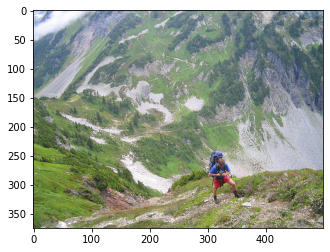

In [82]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

img_path = dataset_images + "/" + os.listdir(dataset_images)[7777]

def extract_features(filename, model):
    image = Image.open(filename)
    image = image.resize((299,299))
    image = np.array(image)
    # convert 4 channels image into 3 channels
    if image.shape[2] == 4:
        image = image[..., :3]
    image = np.expand_dims(image, axis=0)
    image = image/127.5
    image = image - 1.0
    feature = model.predict(image)
    return feature
    

def generate_desc(model, tokenizer, photo, max_length):
    in_text = '<start>'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = tokenizer.index_word[pred]
        in_text += ' ' + word
        if word == '<end>':
            break
    return in_text

tokenizer = load(open("./tokenizer/tokenizer.p","rb"))
model = load_model('./model/model_10_flickr8.h5')
photo = extract_features(img_path, Xception(include_top=False, pooling="avg"))
description = generate_desc(model, tokenizer, photo, max_desc_length)
print("\n")
print(description)
print("Actual: ")
print("\n".join(descriptions[img_path.split("/")[3]]))
img = Image.open(img_path)
plt.imshow(img)

## Evaluate Model

In [83]:
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test_imgs):
    captions = descriptions[key]                                       # get actual caption
    photo = features[key]                                              # get image feature
    y_pred = generate_desc(model, tokenizer, photo, max_desc_length)   # predict caption from our model
    actual_captions = [caption.split()[1:-1] for caption in captions]  # split into words without <start> and <end>
    y_pred = y_pred.split()[1:-1]                                      # split pred also
    actual.append(actual_captions)                                     # append to the list
    predicted.append(y_pred)                                           # append to the list
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.333333, 0.333333, 0.333333, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.458812
BLEU-2: 0.253892
BLEU-3: 0.135658
BLEU-4: 0.069580


### 25 Epoch n batch_size = 32

In [73]:
# train our model
print('Dataset: ', len(train_imgs))
print('Vocabulary Size:', unique_word)
print('Description Length: ', max_desc_length)

if os.path.isfile(("./model/model_25_flickr8.h5")):
    model = load_model("./model/model_25_flickr8.h5")
else:
    model = define_model(unique_word, max_desc_length)
    epochs = 25
    batch_size = 32
    steps = len(train_descriptions)/batch_size

    for i in range(1, epochs+1):
        print("Epoch:", i)
        generator = data_generator(train_descriptions, features, tokenizer, max_desc_length, batch_size)
        model.fit(generator, epochs=epochs, steps_per_epoch= steps, verbose=1)
        model.save("model/model_" + str(i) + "_flickr8.h5")

Dataset:  7281
Vocabulary Size: 8389
Description Length:  34

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 256)      2147584     input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
_______________________________________________



<start> man in blue shirt is hiking on mountain trail <end>
Actual: 
<start> hiker is climbing up very steep mountain <end>
<start> male hiker carries his gear up the snowy mountain <end>
<start> man hikes up huge mountain <end>
<start> hiker in blue shirt and red shorts stands on hill near mountain <end>
<start> the man is hiking up grassy mountainside <end>


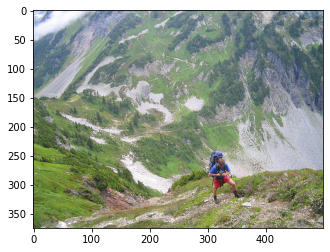

In [36]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

img_path = dataset_images + "/" + os.listdir(dataset_images)[7777]

def extract_features(filename, model):
    image = Image.open(filename)
    image = image.resize((299,299))
    image = np.array(image)
    # convert 4 channels image into 3 channels
    if image.shape[2] == 4:
        image = image[..., :3]
    image = np.expand_dims(image, axis=0)
    image = image/127.5
    image = image - 1.0
    feature = model.predict(image)
    return feature
    
def index_to_word(integer, tokenizer):
    if integer in tokenizer.index_word:
        return tokenizer.index_word[integer]
    return None

def generate_desc(model, tokenizer, photo, max_length):
    in_text = '<start>'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = index_to_word(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == '<end>':
            break
    return in_text

tokenizer = load(open("./tokenizer/tokenizer.p","rb"))
model = load_model('./models/model_25_flickr8.h5')
photo = extract_features(img_path, Xception(include_top=False, pooling="avg"))
description = generate_desc(model, tokenizer, photo, max_desc_length)
print("\n")
print(description)
print("Actual: ")
print("\n".join(descriptions[img_path.split("/")[3]]))
img = Image.open(img_path)
plt.imshow(img)

In [42]:
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test_imgs):
    captions = descriptions[key]                                       # get actual caption
    photo = features[key]                                              # get image feature
    y_pred = generate_desc(model, tokenizer, photo, max_desc_length)   # predict caption from our model
    actual_captions = [caption.split()[1:-1] for caption in captions]  # split into words without <start> and <end>
    y_pred = y_pred.split()[1:-1]                                      # split pred also
    actual.append(actual_captions)                                     # append to the list
    predicted.append(y_pred)                                           # append to the list
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.333333, 0.333333, 0.333333, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.453867
BLEU-2: 0.266741
BLEU-3: 0.157568
BLEU-4: 0.090050


# Indonesian Version

In [32]:
import re
# Get all images with their captions
with open(dataset_text_indo) as file:
    text = file.read()
    text = text.split('\n')
    descriptions = {}
    for line in text[:-1]:
        line = re.split("#\d\t", line)
        img, caption = line[0], line[1]
        if img not in descriptions:
           descriptions[img] = [caption]
        else:
           descriptions[img].append(caption)
print("Length of descriptions =" ,len(descriptions))


#Data cleaning
table = str.maketrans('','',string.punctuation)                             # made table to remove punctutation later
for img, list_of_description in descriptions.items():
    for i, description in enumerate(list_of_description):
        description.replace("-"," ")                                        # convert "-" to " ", ex: "laki-laki" -> "laki laki"
        description = description.lower()                                   # convert all upper case alphabets to lowercase
        description = description.split()                                   # convert string to list
        description = [word.translate(table) for word in description]       # remove punctuation from each token
        description = [word for word in description if(len(word)>1)]        # remove words with 1 letter only
        description = [word for word in description if(word.isalpha())]     # remove words containing numbers
        description = ' '.join(description)                                 # convert back to string
        description = '<start> ' + description + ' <end>'                   # add start and end word
        descriptions[img][i] = description

        
# Find all unique word
words = set()
for list_of_description in descriptions.values():
    for description in list_of_description:
        words.update(description.split())
print("Number of unique word = ", len(words))

Length of descriptions = 8091
Number of unique word =  6783


In [33]:
# Extract features from CNN (Xception)
if os.path.isfile("./features/features.p"): # already extracted before
    features = load(open("./features/features.p","rb"))
    print("Features loaded from dump file")
else:
    model = Xception(include_top=False, pooling="avg")
    features = {}
    for pic_name in tqdm(os.listdir(dataset_images)):
        file = directory + "/" + pic_name
        image = Image.open(file)
        image = image.resize((299,299))
        image = np.expand_dims(image, axis=0)
        image = image/127.5 - 1.0                                           # data normalization
        feature = model.predict(image)                                      # predict with CNN model
        features[pic] = feature                                             # save to dictionary
    dump(features, open("./features/features.p","wb"))                      # save to pickle file (load this file when run again)
    print("Features extracted")

Features loaded from dump file


In [34]:
# Split train and test data
image_ids = list(descriptions.keys())
split = int(len(image_ids) * 0.90)
train_imgs = image_ids[:split]
test_imgs = image_ids[split:]

# Get train description only
train_descriptions = {}
for pic_name in train_imgs:
    if pic_name not in train_descriptions:
        train_descriptions[pic_name] = []
    for description in descriptions[pic_name]:
        train_descriptions[pic_name].append(description)
        
# Get test description only
test_descriptions = {}
for pic_name in test_imgs:
    if pic_name not in test_descriptions:
        test_descriptions[pic_name] = []
    for description in descriptions[pic_name]:
        test_descriptions[pic_name].append(description)

In [35]:
# convert dictionary to clear list of descriptions
train_desc_list = []
for list_of_description in train_descriptions.values():
    for description in list_of_description:
        train_desc_list.append(description)

# Tokenize descriptions
tokenizer = Tokenizer(filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')           # creating tokenizer class
tokenizer.fit_on_texts(train_desc_list)                                         # each integer will represent word
dump(tokenizer, open('./tokenizer/tokenizer_indo.p', 'wb'))                     # save to pickle file (load this file when test model)
unique_word = len(tokenizer.word_index) + 1
print("Unique word:", unique_word)

# calculate maximum length of descriptions for the model parameters.
max_desc_length = max(len(desc.split()) for desc in train_desc_list)
print("Max description length:", max_desc_length)

Unique word: 6503
Max description length: 36


In [36]:
# Data generator, used by model.fit()
def data_generator(descriptions, features, tokenizer, max_length, batch_size = 1):
    x_1, x_2, y = list(), list(), list()
    n = 0
    while 1:
        for key, desc_list in descriptions.items():
            n += 1
            #retrieve photo features
            feature = features[key][0]
            
            # move through each description for the image
            for desc in desc_list:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([desc])[0]
                # divide one sequence into various X,y pairs
                for i in range(1, len(seq)):
                    # divide into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=unique_word)[0]
                    # store
                    x_1.append(feature)
                    x_2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                x_1, x_2, y = np.array(x_1), np.array(x_2), np.array(y)
                yield (x_1, x_2), y
                x_1, x_2, y = list(), list(), list()
                n = 0

# Check the shape of the input and output of the model
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_desc_length, 1))
a.shape, b.shape, c.shape
#((51, 2048), (51, 36), (51, 6503))

((51, 2048), (51, 36), (51, 6503))

In [37]:
# define the captioning model
def define_model(vocab_size, max_length):
    # features from the CNN model compressed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    
    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    merge1 = add([fe2, se3])
    merge2 = Dense(256, activation='relu')(merge1)
    outputs = Dense(vocab_size, activation='softmax')(merge2)

    # merge it [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    return model

### 10 Epoch n batch_size = 1

In [91]:
# train our model
print('Dataset: ', len(train_imgs))
print('Vocabulary Size:', unique_word)
print('Description Length: ', max_desc_length)

if os.path.isfile(("./model/model_indo_10_flickr8.h5")):
    model = load_model("./model/model_indo_10_flickr8.h5")
else:
    model = define_model(unique_word, max_desc_length)
    epochs = 10
    batch_size = 1
    steps = len(train_descriptions)/batch_size

    for i in range(1, epochs+1):
        print("Epoch:", i)
        generator = data_generator(train_descriptions, features, tokenizer, max_desc_length, batch_size)
        model.fit(generator, epochs=epochs, steps_per_epoch= steps, verbose=1)
        model.save("model/model_indo_" + str(i) + "_flickr8.h5")

Dataset:  7281
Vocabulary Size: 6503
Description Length:  36

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 36)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 36, 256)      1664768     input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
_______________________________________________



<start> seorang pria dengan ransel mendaki gunung <end>
Actual: 
<start> seorang pendaki mendaki gunung yang sangat curam <end>
<start> seorang pejalan kaki pria membawa perlengkapannya ke atas gunung bersalju <end>
<start> seorang pria mendaki gunung besar <end>
<start> pejalan kaki dengan kemeja biru dan celana pendek merah berdiri di bukit dekat gunung <end>
<start> pria itu mendaki lereng gunung berumput <end>


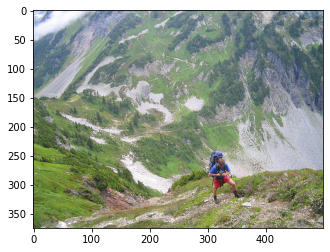

In [94]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

img_path = dataset_images + "/" + os.listdir(dataset_images)[7777]

def extract_features(filename, model):
    image = Image.open(filename)
    image = image.resize((299,299))
    image = np.array(image)
    # convert 4 channels image into 3 channels
    if image.shape[2] == 4:
        image = image[..., :3]
    image = np.expand_dims(image, axis=0)
    image = image/127.5
    image = image - 1.0
    feature = model.predict(image)
    return feature

def generate_desc(model, tokenizer, photo, max_length):
    in_text = '<start>'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = tokenizer.index_word[pred]
        in_text += ' ' + word
        if word == '<end>':
            break
    return in_text

tokenizer = load(open("./tokenizer/tokenizer_indo.p","rb"))
model = load_model('./model/model_indo_10_flickr8.h5')
photo = extract_features(img_path, Xception(include_top=False, pooling="avg"))
description = generate_desc(model, tokenizer, photo, max_desc_length)
print("\n")
print("Predicted: ")
print(description)
print("Actual: ")
print("\n".join(descriptions[img_path.split("/")[3]]))
img = Image.open(img_path)
plt.imshow(img)

In [95]:
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test_imgs):
    captions = descriptions[key]                                       # get actual caption
    photo = features[key]                                              # get image feature
    y_pred = generate_desc(model, tokenizer, photo, max_desc_length)   # predict caption from our model
    actual_captions = [caption.split()[1:-1] for caption in captions]  # split into words without <start> and <end>
    y_pred = y_pred.split()[1:-1]                                      # split pred also
    actual.append(actual_captions)                                     # append to the list
    predicted.append(y_pred)                                           # append to the list
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.333333, 0.333333, 0.333333, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.420818
BLEU-2: 0.262095
BLEU-3: 0.165066
BLEU-4: 0.102062


### 25 Epoch and batch_size = 32

In [98]:
# train our model
print('Dataset: ', len(train_imgs))
print('Vocabulary Size:', unique_word)
print('Description Length: ', max_desc_length)

if os.path.isfile(("./model/model_indo_25_flickr8.h5")):
    model = load_model("./model/model_indo_25_flickr8.h5")
else:
    model = define_model(unique_word, max_desc_length)
    epochs = 25
    batch_size = 32
    steps = len(train_descriptions)/batch_size

    for i in range(1, epochs+1):
        print("Epoch:", i)
        generator = data_generator(train_descriptions, features, tokenizer, max_desc_length, batch_size)
        model.fit(generator, epochs=epochs, steps_per_epoch= steps, verbose=1)
        model.save("model/model_indo_" + str(i) + "_flickr8.h5")

Dataset:  7281
Vocabulary Size: 6503
Description Length:  36
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 36)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 36, 256)      1664768     input_5[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_4[0][0]                    
________________________________________________



Predicted: 
<start> seorang pria sedang mendaki gunung <end>
Actual: 
<start> seorang pendaki mendaki gunung yang sangat curam <end>
<start> seorang pejalan kaki pria membawa perlengkapannya ke atas gunung bersalju <end>
<start> seorang pria mendaki gunung besar <end>
<start> pejalan kaki dengan kemeja biru dan celana pendek merah berdiri di bukit dekat gunung <end>
<start> pria itu mendaki lereng gunung berumput <end>


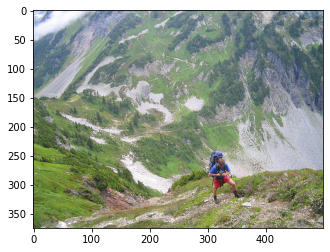

In [39]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

img_path = dataset_images + "/" + os.listdir(dataset_images)[7777]

def extract_features(filename, model):
    image = Image.open(filename)
    image = image.resize((299,299))
    image = np.array(image)
    # convert 4 channels image into 3 channels
    if image.shape[2] == 4:
        image = image[..., :3]
    image = np.expand_dims(image, axis=0)
    image = image/127.5
    image = image - 1.0
    feature = model.predict(image)
    return feature

def generate_desc(model, tokenizer, photo, max_length):
    in_text = '<start>'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = tokenizer.index_word[pred]
        in_text += ' ' + word
        if word == '<end>':
            break
    return in_text

tokenizer = load(open("./tokenizer/tokenizer_indo.p","rb"))
model = load_model('./model/model_indo_25_flickr8.h5')
photo = extract_features(img_path, Xception(include_top=False, pooling="avg"))
description = generate_desc(model, tokenizer, photo, max_desc_length)
print("\n")
print("Predicted: ")
print(description)
print("Actual: ")
print("\n".join(descriptions[img_path.split("/")[3]]))
img = Image.open(img_path)
plt.imshow(img)

In [100]:
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test_imgs):
    captions = descriptions[key]                                       # get actual caption
    photo = features[key]                                              # get image feature
    y_pred = generate_desc(model, tokenizer, photo, max_desc_length)   # predict caption from our model
    actual_captions = [caption.split()[1:-1] for caption in captions]  # split into words without <start> and <end>
    y_pred = y_pred.split()[1:-1]                                      # split pred also
    actual.append(actual_captions)                                     # append to the list
    predicted.append(y_pred)                                           # append to the list
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.333333, 0.333333, 0.333333, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.497193
BLEU-2: 0.334821
BLEU-3: 0.221724
BLEU-4: 0.143111


## Comparison
![Paper preview](./notebook_images/paper.png "Paper preview")



Predicted: 
<start> dua anak lakilaki berlari di rumput <end>
Actual: 
<start> seorang anak lakilaki berpakaian merah dan seorang gadis merah muda sedang berjalan melalui bidang yang dipotong rendah <end>
<start> anak lakilaki dan perempuan kecil berjalan berdampingan <end>
<start> dua anak kecil berjalan pergi di ladang <end>
<start> dua anak kecil berjalan di ladang <end>
<start> dua anak muda berjalan melintasi lapangan terbuka <end>


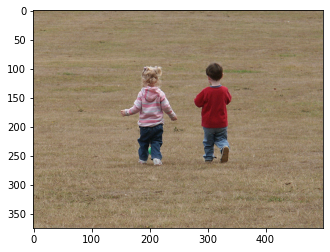



Predicted: 
<start> seorang anak lakilaki mengenakan celana pendek biru dan celana pendek biru melompat di udara di pantai <end>
Actual: 
<start> seorang ayah dengan kedua anaknya di lautan dengan anak lakilaki itu terbang di udara <end>
<start> seorang anak lelaki kecil melompat dari lengan ayahnya di pantai <end>
<start> seorang pria melemparkan seorang anak lakilaki ke udara di pantai <end>
<start> seorang pria dewasa melemparkan seorang anak ke udara di sebuah pantai sementara seorang anak lain mengawasi <end>
<start> seorang anak lakilaki dilemparkan oleh seorang pria ketika seorang gadis menonton di pantai <end>


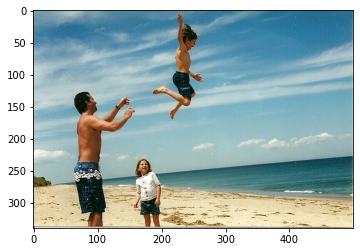



Predicted: 
<start> seorang anak lakilaki dengan kemeja merah muda dan celana pendek biru berdiri di atas rumput <end>
Actual: 
<start> sebuah bola karet raksasa lebih tinggi dari seorang pria dikejar oleh dua pria berbaju oranye <end>
<start> priapria itu berada di atas bukit dengan bola putih raksasa <end>
<start> dua pria berusaha mendorong bola golf tiup yang sangat besar ini <end>
<start> dua pria menggulung bola besar <end>
<start> dua pekerja berwarna oranye dan hitam menyiapkan gelembung <end>


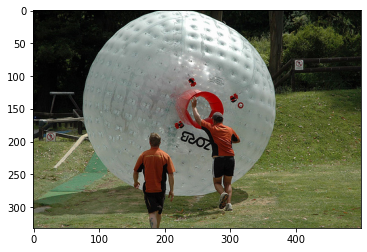

In [54]:
def predict_flickr(img_id):
    img_path = dataset_images + "/" + test_imgs[img_id]
    photo = extract_features(img_path, Xception(include_top=False, pooling="avg"))
    description = generate_desc(model, tokenizer, photo, max_desc_length)
    print("\n")
    print("Predicted: ")
    print(description)
    print("Actual: ")
    print("\n".join(descriptions[img_path.split("/")[3]]))
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    
predict_flickr(7)
predict_flickr(77)
predict_flickr(777)

Predicted: 
<start> dua orang berdiri di dermaga dan satu duduk di atas kapal <end>


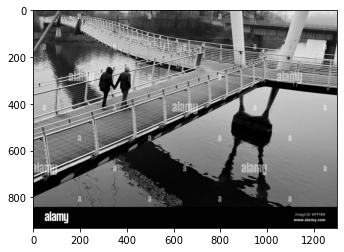

Predicted: 
<start> dua anak berjalan di jembatan tali <end>


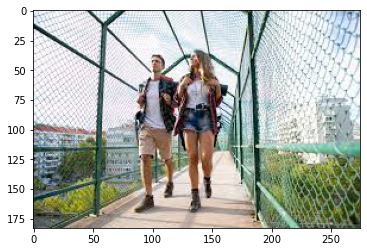

Predicted: 
<start> sekelompok orang berdiri di sekitar jalan <end>


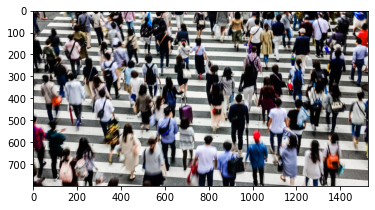

Predicted: 
<start> seekor anjing cokelat kecil berlari di atas bunga kuning di rumput <end>


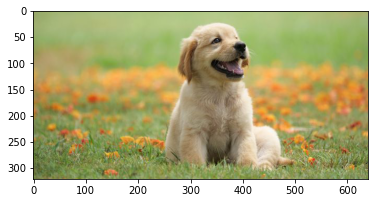

In [47]:
def predict(img_path):
    photo = extract_features(img_path, Xception(include_top=False, pooling="avg"))
    description = generate_desc(model, tokenizer, photo, max_desc_length)
    print("Predicted: ")
    print(description)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    
predict("./test_images/first.jpg")
predict("./test_images/second.jpg")
predict("./test_images/third.jpg")
predict("./test_images/fourth.jpg")